In [1]:
# Copyright 2017 Diogenes Ademir Domingos

# https://opensource.org/licenses/MIT

# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation 
# files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, 
# copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom 
# the Software is furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED 
# TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
# IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
# WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
# OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [2]:
# Configunrando o notebook.
import os
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

# Configunrando o framework Keras.

# Importando a base de dados MNIST (http://yann.lecun.com/exdb/mnist/)
from keras.datasets import mnist

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando o tipo de camada
from keras.layers import Dense

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

# modulo para trabalhar reprocessar as imagens
from keras.preprocessing import image

# modulo de utilizades para trabalhar reprocessar as imagens
from keras.utils.data_utils import get_file

# modulo de callback para parar o treinamento na melhor opção
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Modulo para salvar o modelo em arquivo
from keras.models import model_from_json

# Modolo para carregar um modelo pronto
from keras.models import load_model

# Modulo Scikit-Learn para montar a matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score


#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
# Load dos dados
# Criando uma matriz numpy de dados de treino.
# Criando uma matriz numpy de dados de teste.
# O conjunto de treinamento possui 60.000 exemplos
# O conjunto de testes de 10.000 exemplos

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28)
Rotulos de teste:  (10000,)


In [4]:
# backup para predição

X_test_orig = X_test
print('Dados de teste backup: ', X_test_orig.shape)

Dados de teste backup:  (10000, 28, 28)


In [ ]:
# Amostragem
# Como o conjunto é muito grande para processar na maquina inloco, reduzi criei um subconjunto para experimento.
# Depois de encontrar o melhot modelo, fiz o treinamento com a base integral.

amostra_treino = 5000
mascara = list(range(amostra_treino))
X_train = X_train[mascara]
y_train = y_train[mascara]

amostra_teste = 500
mask = list(range(amostra_teste))
X_test = X_test[mascara]
y_test = y_test[mascara]

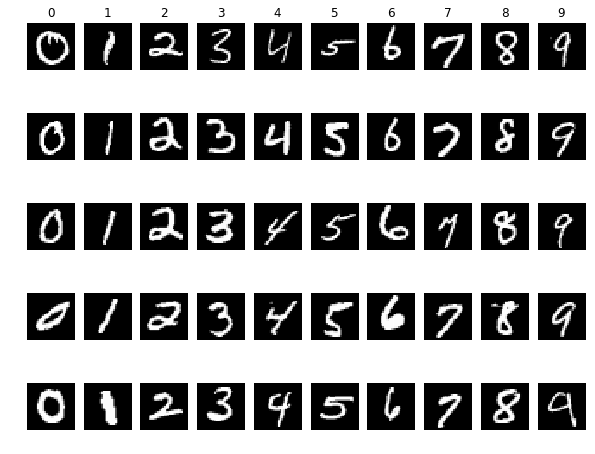

In [5]:
# Visualizando amostra dos dados
# Vetor de classes para indice
classes = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
quantidade_classes = len(classes)
amostras_por_classe = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, amostras_por_classe, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * quantidade_classes + y + 1
        plt.subplot(amostras_por_classe, quantidade_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

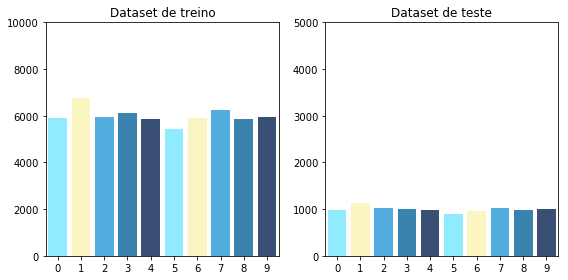

In [6]:
# Visualizando a distribuição do dataset

colors = ['#75E7FF', '#FBF3B3','#289AD7', '#09649A','#082351']

def plot_distribution(y1, y2, data_names, ylims =[10000,10000]): 
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(0.5,10.5), np.bincount(y1), color=colors, alpha=0.8)
    ax1.set_xticks(np.arange(0.5,10.5,1))
    ax1.set_xticklabels(classes, rotation=0, fontsize=10)
    ax1.set_xlim([0, 10])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(0.5,10.5), np.bincount(y2), color=colors, alpha=0.8)
    ax2.set_xticks(np.arange(0.5,10.5,1))
    ax2.set_xticklabels(classes, rotation=0, fontsize=10)
    ax2.set_xlim([0, 10])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train, y_test,
                  ['Dataset de treino', 'Dataset de teste'],
                  ylims =[10000,5000]) 


In [7]:
# Configuração do shape da imagem
# Este shape varia de acordo com o framework de backend
# tenshoflow = (quantidade de canais, largura, altura)
# theano = (largura, altura, quantidade de canais)

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)

(28, 28, 1)


In [8]:
# Alterando os canais de cor para ter apenas um canal
X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')

In [9]:
# Binarizando pixels
X_train = X_train / 255
X_test = X_test / 255

In [10]:
# Visualizando dimensão dos dados.
# (Quantidade, largura, altura)
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28, 1)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28, 1)
Rotulos de teste:  (10000,)


In [ ]:
# Visualizar a matriz de pixels da imagem.
from IPython.display import display
import pandas as pd

print("Formato do dataset: {}".format(X_train.shape))
print("Labels: {}".format(y_train))
print("Labels shape: {}".format(y_train.shape))

# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, len(X_train[0]))
img_aleatoria = X_train[idx_img_aleatoria]
print("Formato da imagem: {}".format(img_aleatoria.shape))

# Visualizar a imagem aleatoria
plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria.reshape(28,28), cmap='hot')
plt.axis('off')

# Imprime os pixels da imagem como tabela
display(pd.DataFrame(img_aleatoria.reshape(28,28)))

In [11]:
# Definindo a qunatidade de neurõnios por camada da RNA

# quantidade de pixels na camada de entrada de dados
# um neuronio para cada pixel
if K.image_data_format() == 'channels_first':
    num_pixels = X_train.shape[2] * X_train.shape[3]
else:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    
print("Quantidade de neurônios (camada entrada): ",num_pixels)

Quantidade de neurônios (camada entrada):  784


In [12]:
# criando a classificação
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [13]:
# verificando a quantidade de classes encontradas
num_classes = y_test.shape[1]
print('Classes encontradas shape: ',y_test.shape)

Classes encontradas shape:  (10000, 10)


In [14]:
# Criando arquitetura da rede DNN
def deep_cnn_model(num_pixels, num_classes, shape, activation='relu'):
    
    # inicialização de hyperparamentros
    # Quantidade de núcleos (Campos receptivos locais)
	nucleos = 32
    # Dimensão dos núcleos
	nucleos_dim_1 = 3
    # Dimensão dos núcleos para maxpooling
	nucleos_dim_2 = 2
    # Quantida de de neuônios para camada totalmente conectada
	neuronios_camada_densa = 128
    
	model = Sequential() # tipo keras senquencial (https://keras.io/getting-started/sequential-model-guide/)
  
    # [Primeira camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade) para entrada de dados. 
    # Camada ConvNet terá 32 núcleos (campos receptivos de 3 x 3 pixels).
    # Arranjo espacial cmo apenas 1 canal de cor e imagem com dimesão de 28 x 28
    # Padding = same, o tamanho da saída será igual ao tamanho da entrada: input=(28,28) -> output=(28,28)
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))  
    # Por default a rede CONV2D já utiliza bias=True e os inicializa com 0
    # Por default o tamanho do passo é 1 pixel, stride=(1,1)
	model.add(Conv2D(nucleos, (nucleos_dim_1, nucleos_dim_1), padding='same', input_shape=shape, activation= activation))
    
    #[Segunda Camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade).
    # Camada ConvNet terá 64 núcleos (campos receptivos de 3 x 3 pixels).
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) 
	model.add(Conv2D(nucleos * 2, (nucleos_dim_1, nucleos_dim_1), activation= activation))
    
    # [Terceira Camada]
    # Adicionando uma camada de subamostragem (MaxPooling2D).
    # Imagens redimensionadas para 2 × 2 pixels.
	model.add(MaxPooling2D(pool_size=(nucleos_dim_2, nucleos_dim_2)))
       
    # [Quarta Camada]
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.25))
    
    # [Quinta camada]
    # Achata o vetor
    # Aprimora a entrada, tranforma uma imagem de input=(13,13) e com 64 núcleos, em um vetor de 10.816 posições (28*28*64)
    # Não afeta o tamanho do lote.
	model.add(Flatten())
    
    #[Sexta Camada]
    # Adicionando camada densa (totalmente conectada), destinada a classificação.
    # Possui 128 neurônios de entrada.
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Dense(neuronios_camada_densa, activation= activation))
    
    #[Sétima camada]
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.50))
        
    #[Oitava Camada]
    # Adicionando uma camada densa (totalmente conectada) para saída de dados, 
    # Função de ativação do neurônio será Softmax (https://en.wikipedia.org/wiki/Softmax_function)
    # Nome da camada de saída é predição (Opcional)
	model.add(Dense(num_classes, activation='softmax', name='preds'))
    
    # Função para otimização estocástica, requer apenas gradientes de primeira ordem com pouco requisito de memória.
    # Referência: (KINGMA, Diederik; BA, Jimmy. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.)
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
	# adam = keras.optimizers.Adam(lr=0.01, decay=1e-6)
	#adadelta = keras.optimizers.Adadelta()
        
    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    # utilizão adam padrão, sem alterar lr.
	#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    # retorna o modelo compilado
	return model

In [15]:
# instanciando o modelo RNA
model = deep_cnn_model(num_pixels, num_classes, shape)

In [16]:
# Descrevendo a representação do modelo DNN
# Arranjo dimensional: 
# 1 camada de entrada;
# 2 camadas ocultas;
# 1 camada de saída (preds);
# quantidade de parâmentros da rede (pesos).
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1384576   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [26]:
# Verificando o arranjo espacial do modelo
for i, layer in enumerate(model.layers):
    if i == 2:
        print ("Camada", i, "\tname: ", layer.name.strip(),"\tinput:", layer.input_shape, "\toutput: ", layer.output_shape)
    elif i == 5 or i == 6:
        print ("Camada", i, "\tname", layer.name.strip(),"\t\tinput:", layer.input_shape, "\t\toutput: ", layer.output_shape)
    elif i == 7:
        print ("Camada", i, "\tname", layer.name.strip(),"\t\tinput:", layer.input_shape, "\t\toutput: ", layer.output_shape)
    else:
        print ("Camada", i, "\tname", layer.name.strip(),"\t\tinput:", layer.input_shape, "\toutput: ", layer.output_shape)

Camada 0 	name conv2d_1 		input: (None, 28, 28, 1) 	output:  (None, 28, 28, 32)
Camada 1 	name conv2d_2 		input: (None, 28, 28, 32) 	output:  (None, 26, 26, 64)
Camada 2 	name:  max_pooling2d_1 	input: (None, 26, 26, 64) 	output:  (None, 13, 13, 64)
Camada 3 	name dropout_1 		input: (None, 13, 13, 64) 	output:  (None, 13, 13, 64)
Camada 4 	name flatten_1 		input: (None, 13, 13, 64) 	output:  (None, 10816)
Camada 5 	name dense_1 		input: (None, 10816) 		output:  (None, 128)
Camada 6 	name dropout_2 		input: (None, 128) 		output:  (None, 128)
Camada 7 	name preds 		input: (None, 128) 		output:  (None, 10)


In [34]:
# Verificando o arranjo espacial do modelo com o pesos
# W.shape = matriz de pesos (quantidade de entradas, quantidade de saídas)
# b.shape = matriz de viés(bias)
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        if i == 7:
            print("Camada", i, "\tname:", layer.name.strip(), "\tpesos:", W.shape, "\tbias:", b.shape)
        else:
            print("Camada", i, "\tname:", layer.name.strip(), "\tpesos:", W.shape, "\tbias:", b.shape)

Camada 0 	name: conv2d_1 	pesos: (3, 3, 1, 32) 	bias: (32,)
Camada 1 	name: conv2d_2 	pesos: (3, 3, 32, 64) 	bias: (64,)
Camada 5 	name: dense_1 	pesos: (10816, 128) 	bias: (128,)
Camada 7 	name: preds 	pesos: (128, 10) 	bias: (10,)


In [ ]:
# Retorna a configuração do modelo DNN
model.get_config()

In [ ]:
# Verificando os pesos da DNN
model.get_weights()

In [35]:
# monitor para ouvir e parar o treinamento caso o aprendizado comece a cair
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

In [36]:
# chekpoint para salvar o mehlor aprendizado enter as epocas
checkpoint = ModelCheckpoint('melhor_modelo_treinado.h5',  # nome para o modelo salvo
                             monitor= monitor.monitor, # qual parametro vai acompanhar
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # sobreescreve o modelo apenas se for o melhor
                             mode='auto') # dependecia de acorco com o monitor

In [37]:
# Treinando o modelo DNN para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino

PESOS_SALVOS = 'mnist_cnn_weights.hdf'
if True and os.path.exists(PESOS_SALVOS):
    # Just change the True to false to force re-training
    print('Loading existing weights')
    model.load_weights(PESOS_SALVOS)
else:
    # treinando a DNN para 1 épocas
    #callbacks=[monitor]
    # model.load_weights(PESOS_SALVOS) # apenas para ter o history, ler e executar por 1 temporada
    %time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[monitor],epochs=1, batch_size=128, verbose=1)
    #model.save_weights(PESOS_SALVOS)
    

Loading existing weights


In [38]:
# Avaliando o modelo DNN
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=0)
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
Erro de: 0.88%
Precisão de: 99.12%


In [94]:
# Historico do treino
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [ ]:
# Historio de precição
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Treino e validação: precisão')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Treino e validação: perda')

plt.show()

In [40]:
# utilizando o modelo para predição.
predicted = model.predict(X_test,batch_size=30, verbose=1).argmax(-1)
print('\nQuantidade de imagens analisadas: ', predicted.shape)

 9990/10000 [============================>.] - ETA: 0s
Quantidade de imagens analisadas:  (10000,)


In [41]:
print(model.predict(X_test[1:5]))
print(y_test[1:5])

[[  2.08310365e-08   7.54788459e-07   9.99999166e-01   6.84412527e-11
    1.68090875e-10   5.94273234e-14   9.06836828e-09   4.27016018e-12
    5.53198265e-10   9.74597718e-15]
 [  1.11110424e-07   9.99992132e-01   3.28792652e-07   1.39620635e-08
    3.54012377e-06   4.64357157e-08   9.23308846e-07   2.00601357e-06
    8.39061101e-07   2.35873436e-08]
 [  9.99991298e-01   1.60992144e-08   5.98013798e-07   4.15253698e-09
    6.31989749e-08   5.63449065e-09   4.97891460e-06   2.08314304e-06
    9.41685272e-08   7.99112968e-07]
 [  9.82026016e-09   2.52052445e-07   1.74167070e-09   1.12375609e-10
    9.99986410e-01   4.19853735e-11   5.99666450e-09   6.25152907e-08
    5.54550050e-09   1.31996112e-05]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [46]:
test_image = X_test[0:1]
print (test_image.shape)

#print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

(1, 28, 28, 1)
1/1 [==============================] - 0s
[7]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


In [49]:
Y_pred = model.predict(X_test, verbose=1)
print()
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

 9984/10000 [============================>.] - ETA: 0s
[[  2.61173028e-10   5.05025755e-09   1.61651386e-08 ...,   9.99999881e-01
    1.88350779e-09   1.56645115e-07]
 [  2.08310365e-08   7.54788459e-07   9.99999166e-01 ...,   4.27016018e-12
    5.53197266e-10   9.74597718e-15]
 [  1.11110211e-07   9.99992132e-01   3.28792026e-07 ...,   2.00601153e-06
    8.39061101e-07   2.35873898e-08]
 ..., 
 [  6.66876819e-13   4.76817519e-08   3.50741680e-13 ...,   2.32191333e-08
    4.84628204e-09   6.00478316e-08]
 [  1.04341593e-08   3.93812205e-10   2.28211044e-11 ...,   3.65120267e-10
    3.11639451e-05   7.19023785e-10]
 [  9.04579611e-09   7.93960619e-10   5.48533130e-08 ...,   3.60993223e-12
    1.01164259e-08   2.07142678e-10]]
[7 2 1 ..., 4 5 6]


In [50]:
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=classes))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       0.99      1.00      1.00      1135
          2       0.99      0.99      0.99      1032
          3       0.99      1.00      0.99      1010
          4       1.00      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.99      1009

avg / total       0.99      0.99      0.99     10000



In [51]:
# prediction and true labels
y_prob = model.predict(X_test, batch_size=30, verbose=1)
y_pred2 = [np.argmax(prob) for prob in y_prob]
y_true2 = [np.argmax(true) for true in y_test]

 9990/10000 [============================>.] - ETA: 0s

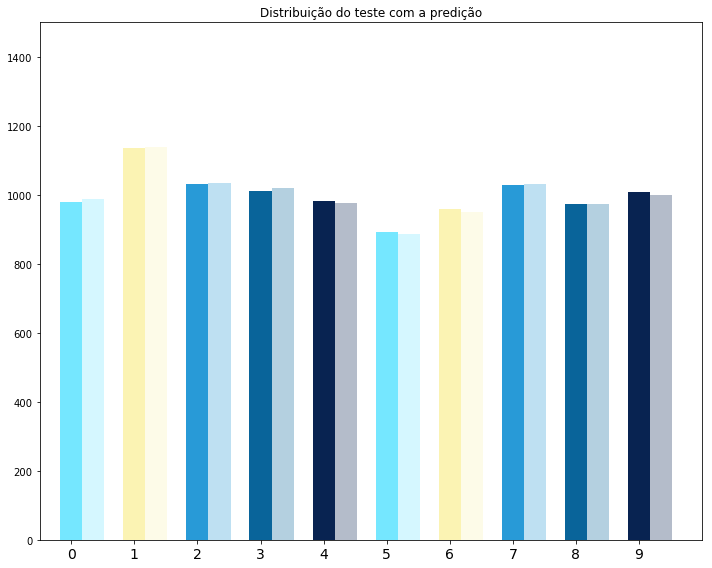

In [52]:
# Verificando a distribução da predição
def plot_distribution(y_true, y_pred):
    ind = np.arange(0.5,10.5,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colors, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colors, alpha=0.3)
    ax.set_xticks(np.arange(0.5,10.5,1))
    ax.set_xticklabels(classes, rotation=0, fontsize=14)
    ax.set_xlim([0, 10.5])
    ax.set_ylim([0, 1500])
    ax.set_title('Distribuição do teste com a predição')
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_true2, y_pred2)

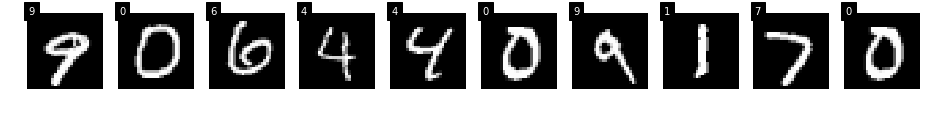

In [57]:
# Visualizando e comparando a predição com a base original.
amosta = 10
plt.figure(figsize=(16,8))
for i in range(amosta):
    plt.subplot(1, amosta, i+1)
    # Seleciona uma imagem aleatoria
    idx_img_aleatoria = random.randint(0, len(X_train[0]))
    img_aleatoria = X_test[idx_img_aleatoria]
    
    # Visualiza a imagem escolhida aleatoriamente
    plt.imshow(img_aleatoria.reshape(28,28), interpolation='nearest')
    
    # Visualiza o label
    plt.text(0, 0, predicted[idx_img_aleatoria], color='white', 
             bbox=dict(facecolor='black', alpha=1))
    plt.axis('off')

In [53]:
# Visualizando e comparando a predição com a base original.

def plot_numeros(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
   
    for i in range(start, end+1):
        input_img = X_test[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,:].reshape(28,28), cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(classes[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(classes[y_true[i]], fontsize=12)
        if title:
            plt.title(classes[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [54]:
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X_test[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        colors = ['#624ea7', 'g', 'yellow', 'k', 'maroon','#624ea7']
        ax.bar(np.arange(0,10), y_prob[i], color=colors,alpha=0.5)
        ax.set_xticks(np.arange(0,10,1))
        ax.set_xticklabels(classes, rotation=0, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [55]:
def plot_numeros_com_probs(start, end, y_prob):
    iter = (end - start)/6
    for i in np.arange(0,iter):
        plot_numeros(int(i*6), int(i+1)*6-1 , y_pred2, y_true2, title=False)
        plot_probs(int(i*6), int((i+1)*6-1), y_prob)

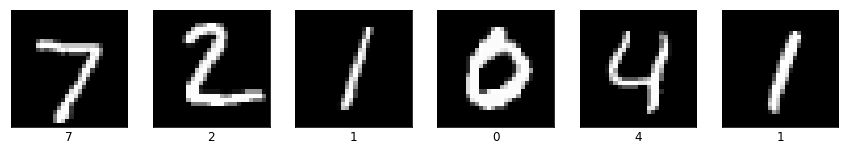

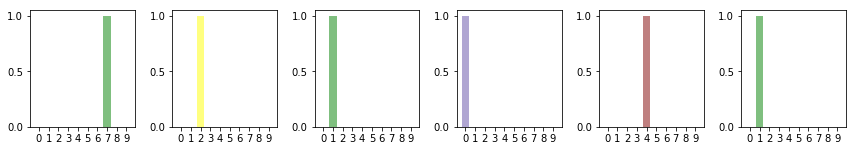

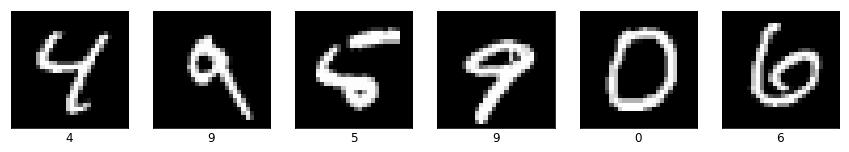

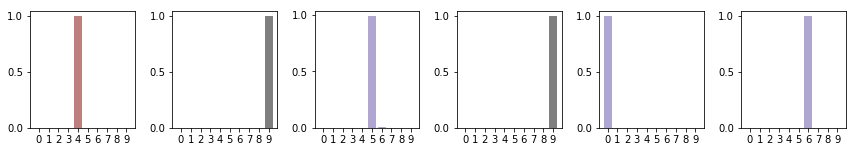

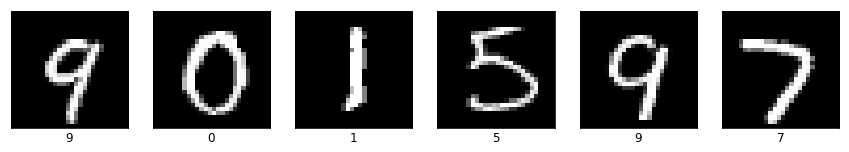

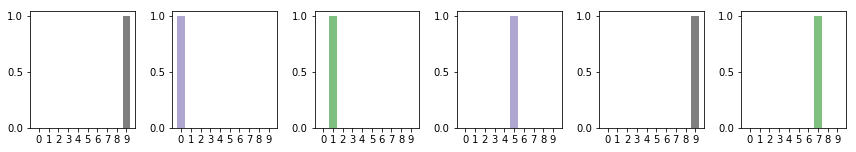

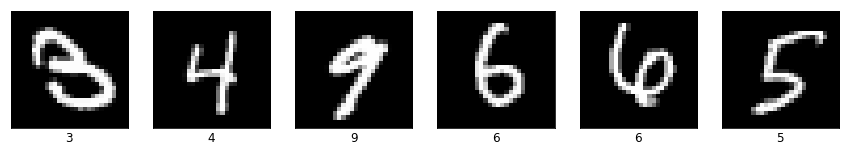

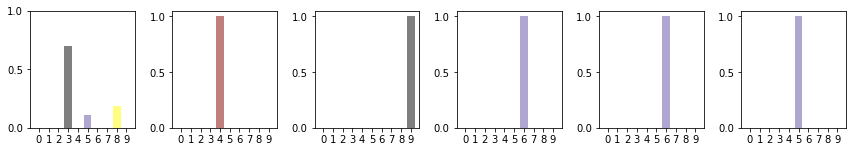

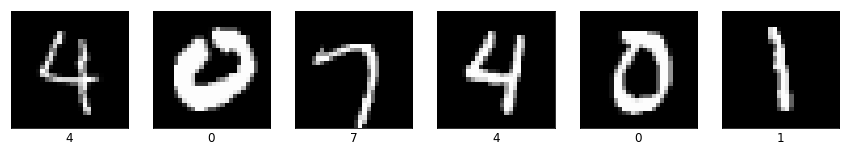

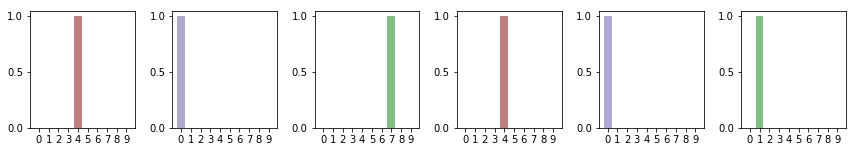

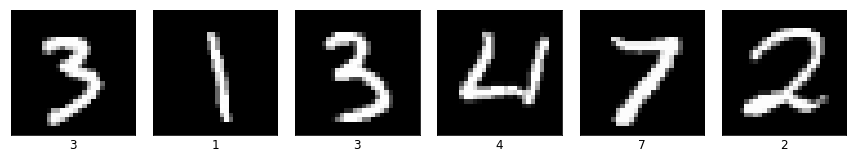

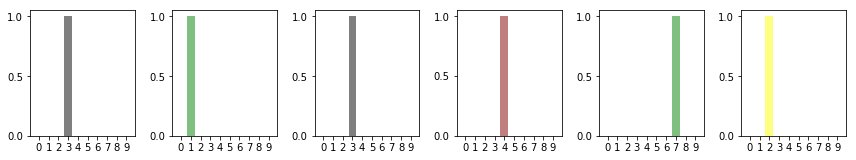

In [56]:
import matplotlib
plot_numeros_com_probs(0, 36, y_prob)

In [58]:
# Função para matriz de confusão da predição
# Referência: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Base de teste')
    plt.xlabel('Predições')

Verificando formato dos dados da predição: (10000,)
Verificando formato dos dados de testes: (10000, 10)


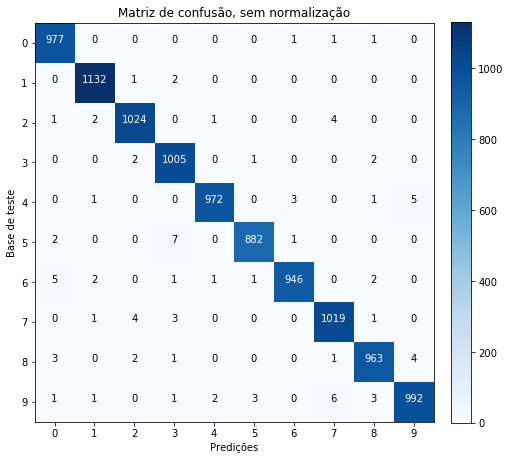

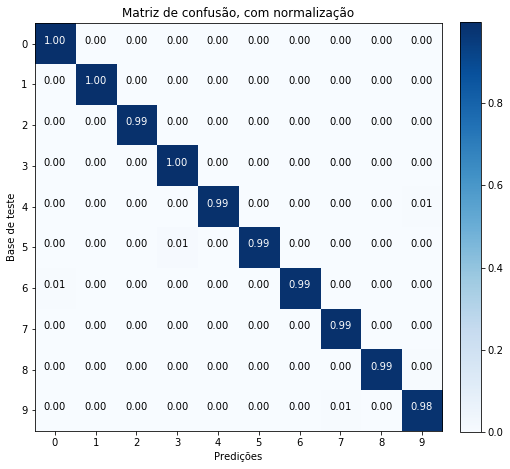

In [59]:
# Visualizando matriz de confusão da predição

# Precisa ter o mesmo formato
print('Verificando formato dos dados da predição: {}'.format(predicted.shape))
print('Verificando formato dos dados de testes: {}'.format(y_test.shape))

cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), predicted)
np.set_printoptions(precision=2)

# Visualizando a matriz de confusão sem normalização.
# mosta a quantidade de imagens classificadas para cada label
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Matriz de confusão, sem normalização')

# Visualizando a matriz de confusão com normalização.
# mosta a precisão para cada label classificado
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Matriz de confusão, com normalização')

plt.show()

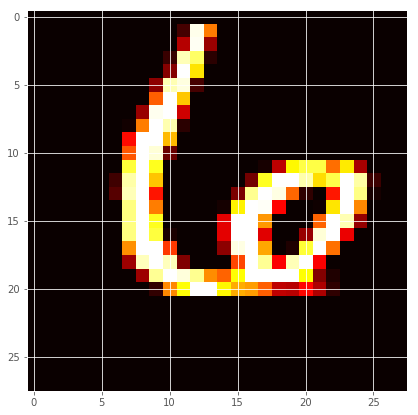

In [51]:
# Visualizando o mapa de calor

# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, X_test.shape[0])
img_aleatoria = X_test_orig[idx_img_aleatoria]

input_img_data = X_test[idx_img_aleatoria].reshape(28,28)
plt.figure(figsize=(7,7))
plt.imshow(input_img_data, cmap="hot")

In [52]:
input_img_data = np.expand_dims(input_img_data, axis=0)
print('Input image shape:', input_img_data.shape)

Input image shape: (1, 28, 28)


In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1384576   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [54]:
# Listando as camadas da rede
from collections import OrderedDict
layer_dict = OrderedDict()
for layer in model.layers[0:]:
    layer_dict[layer.name] = layer
    print(layer.name)

conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
preds


In [55]:
# Buscando as ativações da camada de convolucao

def get_activations(model, layer, input_img_data):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((input_img_data, False))
    return activations

In [56]:
# Verificando o shape

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)
print(input_img_data.shape)
input_img_data = input_img_data.reshape((input_img_data.shape[0],) + shape).astype('float32')
print(input_img_data.shape)

(28, 28, 1)
(1, 28, 28)
(1, 28, 28, 1)


In [57]:
# Pegando as ativações
layer_name = 'conv2d_2'
layer = layer_dict[layer_name]
activations = get_activations(model, layer, input_img_data)

In [58]:
# Visualizando o shape da primeira ativação
print(len(activations))
print(np.shape(activations)) # (1,1,largura,altura,nucleos) = tensorflow
                             # (1,1,nucloes,largura,altura) = theano

activation = activations[0][0]
print(activation.shape)      # (1,largura,altura,nucleos) = tensorflow
                             # (1,nucloes,largura,altura) = theano


1
(1, 1, 26, 26, 64)
(26, 26, 64)


In [59]:
if K.image_dim_ordering() =='th':
    activation = np.rollaxis((np.rollaxis(activation,2,0)),2,0)
    print('Theano: ',activation.shape)
print('Tensorflow: ',activation.shape)

Tensorflow:  (26, 26, 64)


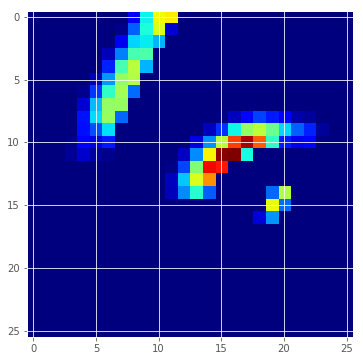

In [60]:
fig = plt.figure(figsize=(6,6))
plt.imshow(activation[:,:,0], cmap='jet')

In [61]:
# Quantidade de núcleos
print('Quantidade de núcleos na camada: ',layer.filters)

Quantidade de núcleos na camada:  64


Quantidade de núcleos na imagem:  64


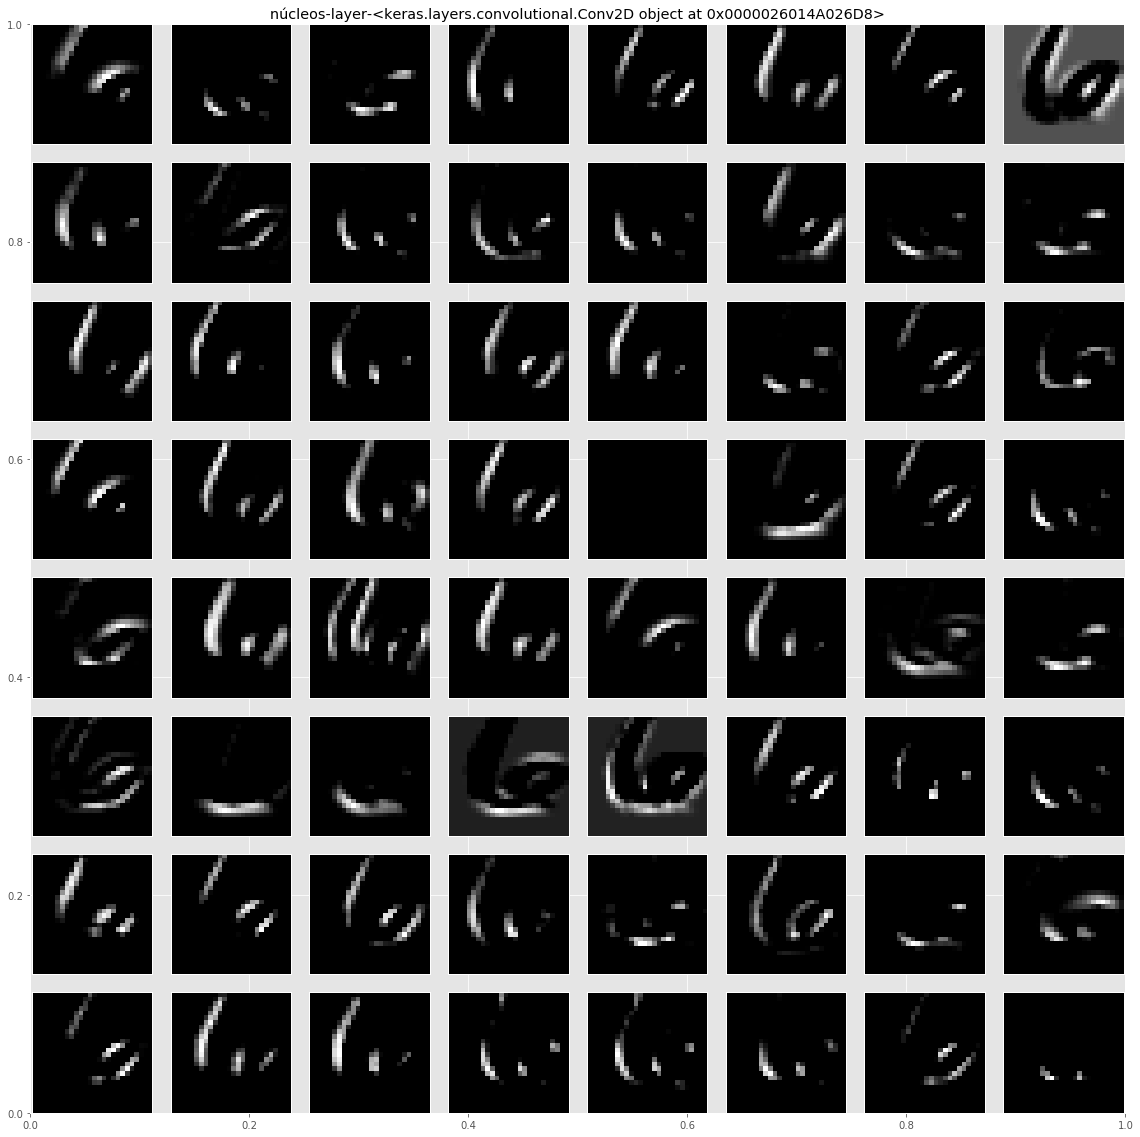

In [62]:
# Visualizando as ativações da imagem através das camadas convoluídas

activated_img = activation.shape[2]
print("Quantidade de núcleos na imagem: ",activated_img)

# Para visualizar todos os núcleos usar = int(np.sqrt(layer.filters)) # raiz 64 núcleos, gera plot 8 x 8
# Visualizando apenas todos núcleos
fig=plt.figure(figsize=(16,16))
plt.title("núcleos-layer-{}".format(layer))
subplot_num=int(np.ceil(np.sqrt(activated_img)))

for i in range(int(activated_img)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)

    # Algums mapas de cor: Paired, CMRmap_r, Accent, nipy_spectral, gnuplot, gnuplot2, hot_r, jet, ocean_r
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(activation[:,:,i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
# para salvar os nucloes em arquivo
# fig.savefig("nucloes-layer-{}".format(model.layers[0]) + '.jpg')

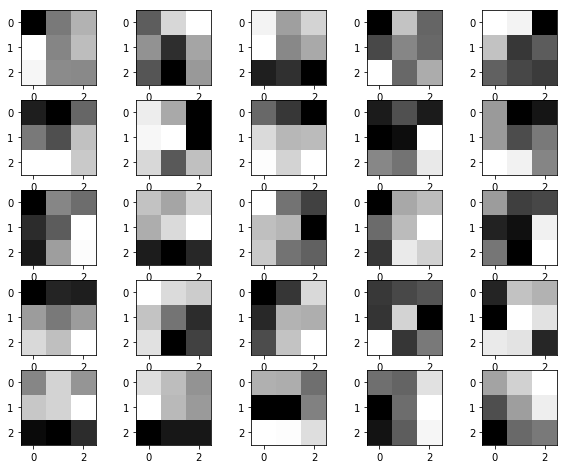

In [92]:
camada = model.layers[0] # conv2d_2
pesos = camada.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(pesos[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [39]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

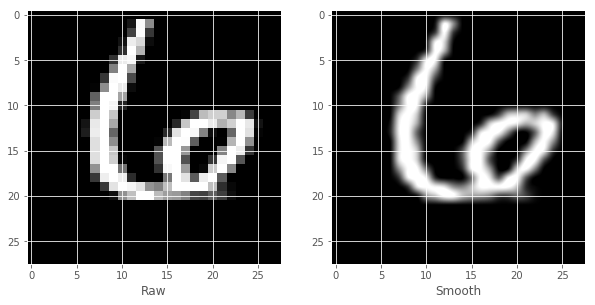

In [64]:
plot_image(img_aleatoria)

In [63]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [57]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, 28, 28)) * 20 + 128.

In [ ]:
plt.imshow(input_img_data[0])

In [ ]:

img = input_img_data[0]
img = deprocess_image(img)
# Mostrar a imagem pela média
plt.imshow(img)
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

In [ ]:
# proximo passo é aletar a ativação da camada de relu para softmax, 
# para poder visualizar as caracteristas linearmente separáveis do núcleo

In [92]:

print("Salvando o modelo...")
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Modelo salvo em arquivo com sucesso!")

Saved model to disk


In [93]:
# Lendo o modelo salvo em arquivo
print("Carregando o modelo...")
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Carregamento completo!")

model.save('model.hdf5')
loaded_model=load_model('model.hdf5')

Loaded model from disk


In [132]:
# Visualiazar as ativações das camadas DNN
from keras.preprocessing import image

#Imagem aleatoria
img_tensor = image.img_to_array(img_aleatoria)

# adicionar tenser 4D
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# shape é (1, 128, 98, 3)
print(img_tensor.shape)

(1, 28, 28, 1)


(28, 28, 1)


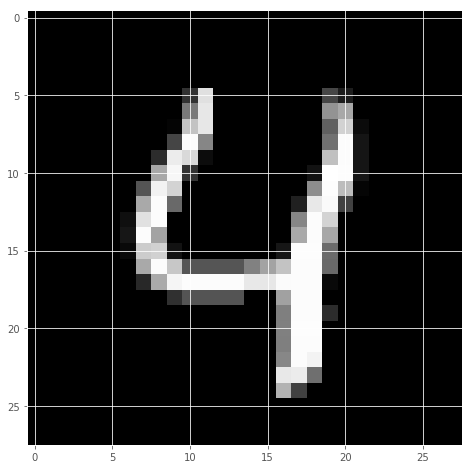

In [137]:
print(img_aleatoria.shape)
plt.imshow(img_aleatoria.reshape(28,28), interpolation='nearest')

In [183]:
# Selecionando todas as camadas de saida da rede

layer_outputs = [layer.output for layer in model.layers[:3]]
print(len(layer_outputs))

3


In [184]:
# Criando novo modelo para trabalhar com as ativações dos núclos

from keras.models import Model
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [185]:
# visualiza arquitetura do novo modelo
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [186]:
# realiza a predicao com o novo modelo
activations_new = activation_model.predict(img_tensor)

In [187]:
# Separa a primeira camada convoluida
first_layer_activation = activations[0]

In [188]:
# Verifica shape para plot
# tem 64 núcloes nessa camada
print(first_layer_activation.shape)

(1, 26, 26, 64)


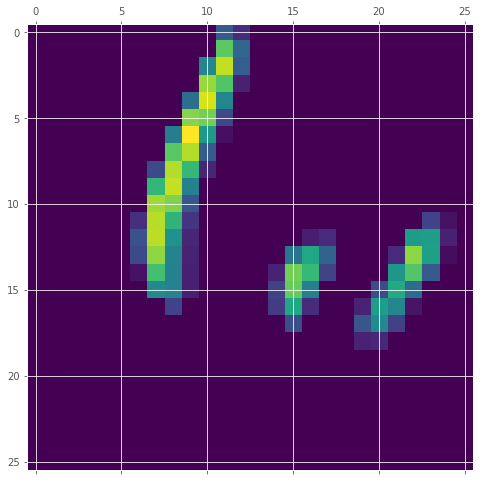

In [189]:
# Escolhe um nucleo para visualizar

idx_nucleo = 5
plt.matshow(first_layer_activation[0, :, :, idx_nucleo], cmap='viridis')

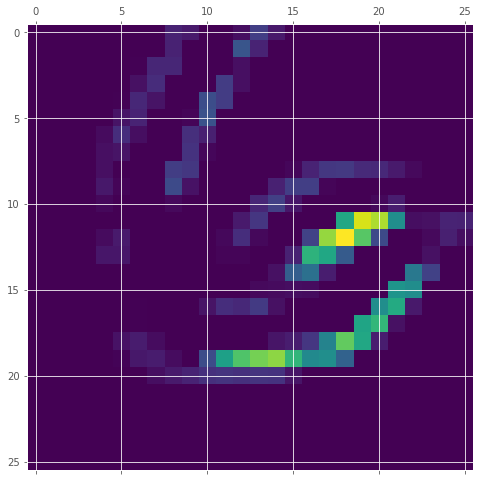

In [190]:
# escolhe outro núcleo

idx_nucleo = 40
plt.matshow(first_layer_activation[0, :, :, idx_nucleo], cmap='viridis')

C:\Users\kfus\Anaconda3\envs\mnist\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


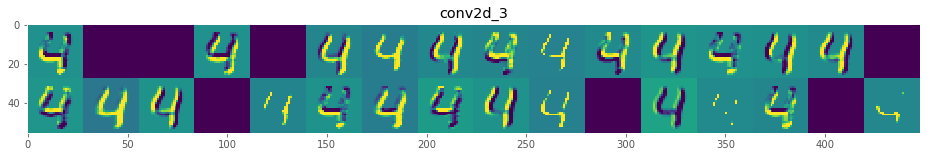

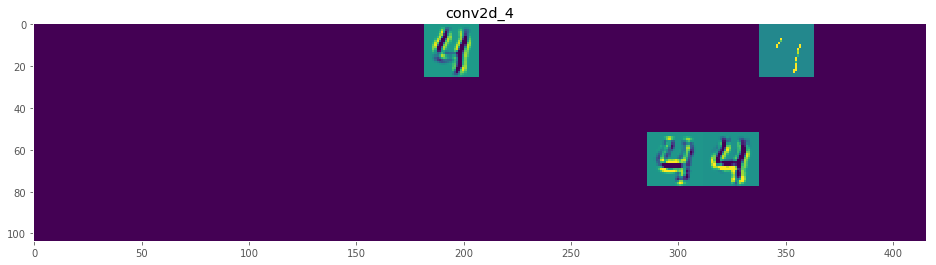

In [191]:
# Visualizar todas as ativações

# separando apenas as camadas que são de convolução.
layer_names = []
for layer in model.layers[:3]:
    if isinstance(layer, Conv2D): # Testa se é uma camada de convolução
        layer_names.append(layer.name)

# Separando a quantidade de imagens por linda do plot
images_per_row = 16

# Mapa de ativações
for layer_name, layer_activation in zip(layer_names, activations_new):
    
    # Quantidade de nucleos
    n_features = layer_activation.shape[-1]

    # tamanho do imagem = shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Paramentros do grid
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Plot do grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [193]:
# Visulizar os pesos
# Desconvnet
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [195]:
def generate_pattern(layer_name, filter_index, size=28):
    
    # Construindo a função de perda que maximixa a ativação
    # de todas as saídas da rede
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Calculando o gradiente da entrada da imagem pela função da perda
    grads = K.gradients(loss, model.input)[0]

    # Normaçlizando o gradiente
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # Função para pegar a perda e o gradiente
    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 1)) * 20 + 128

    # Executa o gradiente na imagem
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

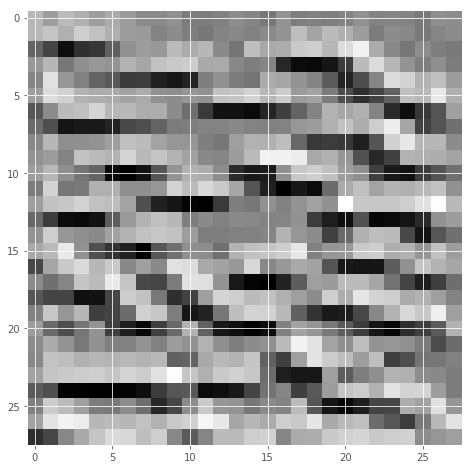

In [202]:
# Visualizando a plicação do gradiente
plt.imshow(generate_pattern('conv2d_3', 0).reshape((28,28)))

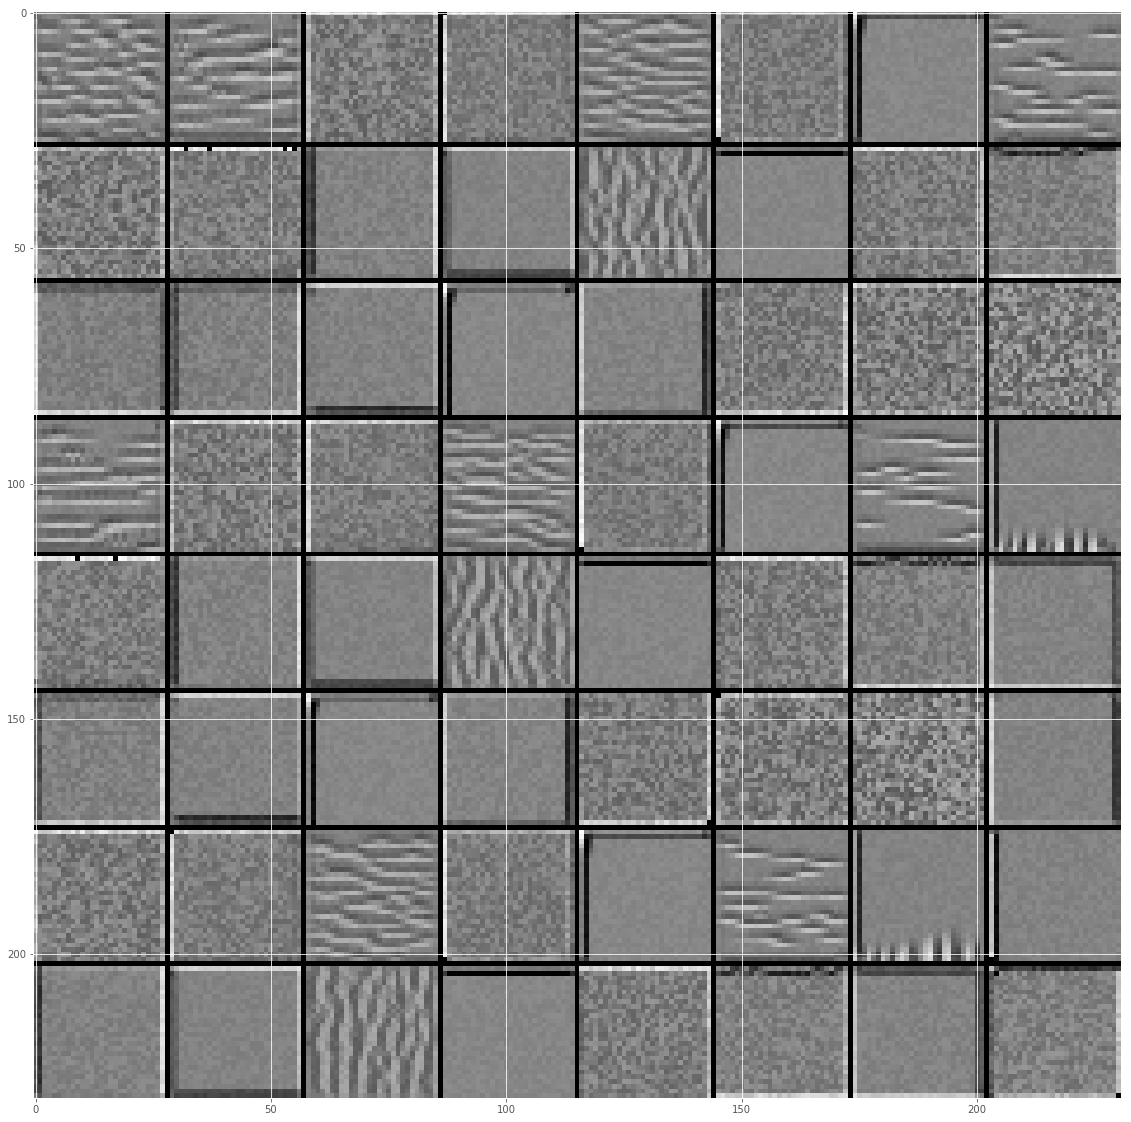

In [213]:
# Verificando todos os pesos pelo gradiente
size = 28
margin = 1

# matriz vazia para guardar os resultados
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):  # linha
    for j in range(8):  # Coluna
        
        # Gerando o gradiente para todos os núcleos da camanda
        filter_img = generate_pattern(layer_name, i + (j * 3), size=size)

        # Aloca o resultado na matriz
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

# Visualiza o grid
plt.figure(figsize=(16, 16))
plt.imshow(results, cmap = "viridis")

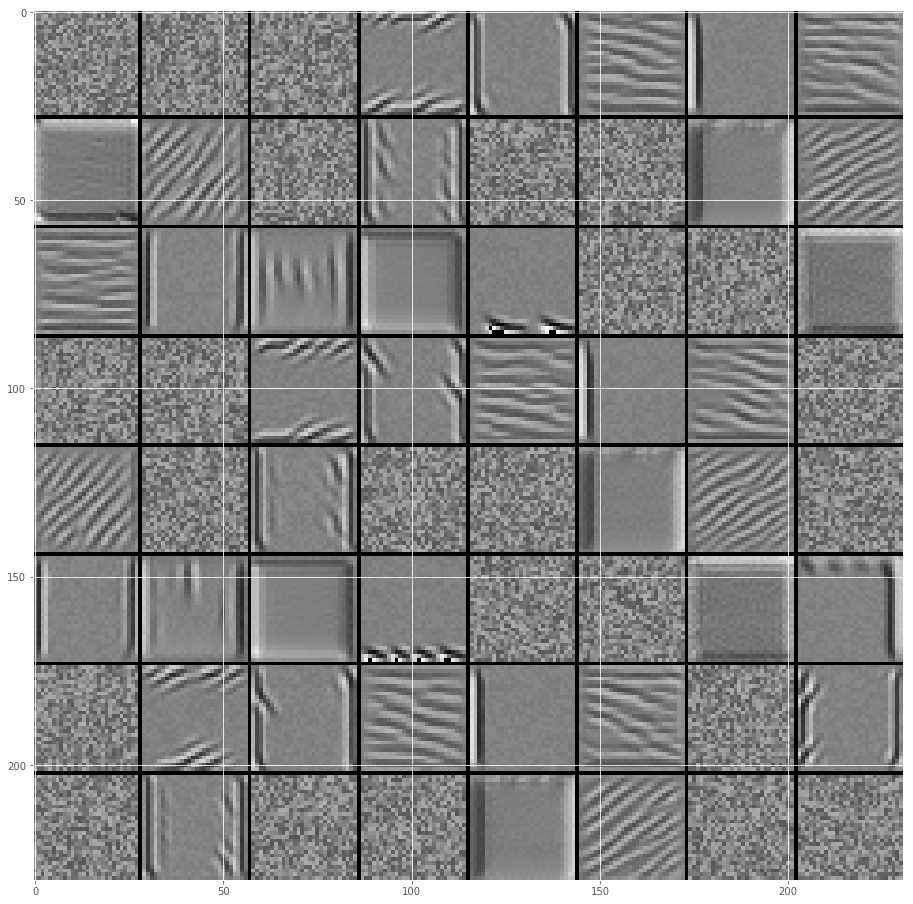

In [214]:
layer_name = 'conv2d_4'
size = 28
margin = 1

# matriz vazia para guardar os resultados
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):  # linha
    for j in range(8):  # coluna
        
        # Gerando o gradiente para todos os núcleos da camanda
        filter_img = generate_pattern(layer_name, i + (j * 3), size=size)

        # Aloca o resultado na matriz
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

# Visualiza o grid
plt.figure(figsize=(16, 16))
plt.imshow(results, cmap = "viridis")